<a href="https://colab.research.google.com/github/graviraja/100-Days-of-NLP/blob/architectures/architectures/Naive%20Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports

In [98]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [135]:
import re
import spacy
import numpy as np
import pandas as pd

from nltk.corpus import stopwords

from sklearn.datasets import fetch_20newsgroups
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics

import gensim
from gensim.utils import simple_preprocess

import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

In [100]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
np.random.seed(42)

In [101]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

nlp = spacy.load('en', disable=['parser', 'ner'])

### Newsgroup Dataset

In [144]:
train_dataset = fetch_20newsgroups(subset="train", shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))
test_dataset = fetch_20newsgroups(subset="test", shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))
len(train_dataset.data), len(test_dataset.data)

(11314, 7532)

In [145]:
train_dataset.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

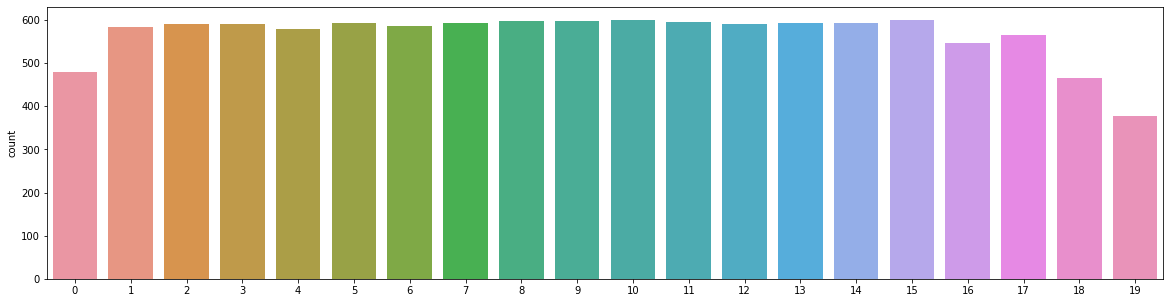

In [146]:
plt.figure(figsize=(20, 5))
sns.countplot(train_dataset.target)

### Pre-processing

In [147]:
def sentence_to_tokens(sent):
    # remove emails
    sent = re.sub(r'\S*@\S*\s?', '', sent)
    # remove newline chars
    sent = re.sub(r'\s+', ' ', sent)
    # remove single quotes
    sent = re.sub(r"\'", "", sent)
    # converts to lower case tokens and removes tokens that are
    # too small & too long. Also remove accent characters & punct
    tokens = simple_preprocess(str(sent), deacc=True)
    return tokens

In [150]:
%%time
tokenized_train_data = [sentence_to_tokens(doc) for doc in train_dataset.data]
tokenized_test_data = [sentence_to_tokens(doc) for doc in test_dataset.data]

CPU times: user 9.82 s, sys: 186 ms, total: 10 s
Wall time: 10 s


In [151]:
" ".join(tokenized_train_data[0])

'was wondering if anyone out there could enlighten me on this car saw the other day it was door sports car looked to be from the late early it was called bricklin the doors were really small in addition the front bumper was separate from the rest of the body this is all know if anyone can tellme model name engine specs years of production where this car is made history or whatever info you have on this funky looking car please mail'

In [152]:
%%time
# create bigrams from the tokenized data
bigram = gensim.models.Phrases(tokenized_train_data, threshold=50)
# make a bigram model
bigram_mod = gensim.models.phrases.Phraser(bigram)

CPU times: user 11 s, sys: 43.8 ms, total: 11 s
Wall time: 11 s


In [153]:
def process_words(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    # remove stopwords
    stop_free = [[word for word in doc if word not in stop_words] for doc in texts]
    # bigrams
    bigram_data = [bigram_mod[doc] for doc in stop_free]

    texts_out = []
    for sent in bigram_data:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]  
    # join words into sentence in-order to make it useful to tfidf processing
    texts_out = [" ".join(words) for words in texts_out]
    return texts_out

In [154]:
%%time
processed_train_data = process_words(tokenized_train_data)
processed_test_data = process_words(tokenized_test_data)

CPU times: user 2min 19s, sys: 1.58 s, total: 2min 21s
Wall time: 2min 21s


In [155]:
processed_train_data[0]

'wonder could enlighten car see day door look late early call bricklin door really small addition separate rest body know tellme model name engine year production car make history info funky look car mail'

### Count Vectorization

In [156]:
count = CountVectorizer()

train_data_count_vectorized = count.fit_transform(processed_train_data)
test_data_count_vectorized = count.transform(processed_test_data)

In [157]:
X_train = train_data_count_vectorized
y_train = train_dataset.target
X_test = test_data_count_vectorized
y_test = test_dataset.target

In [158]:
print(f"Number of training samples: {len(y_train)}")
print(f"Number of testing samples: {len(y_test)}")

Number of training samples: 11314
Number of testing samples: 7532


Text(0.5, 0, 'Training distribution')

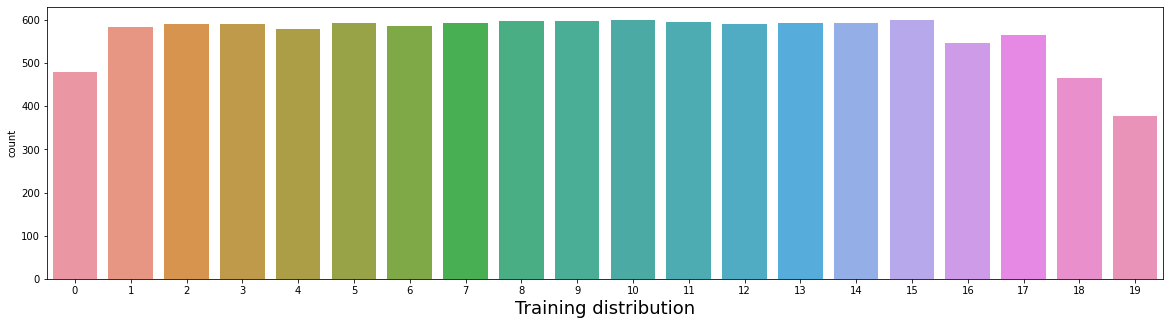

In [159]:
plt.figure(figsize=(20, 5))
sns.countplot(y_train)
plt.xlabel("Training distribution", fontsize=18)

Text(0.5, 0, 'Testing distribution')

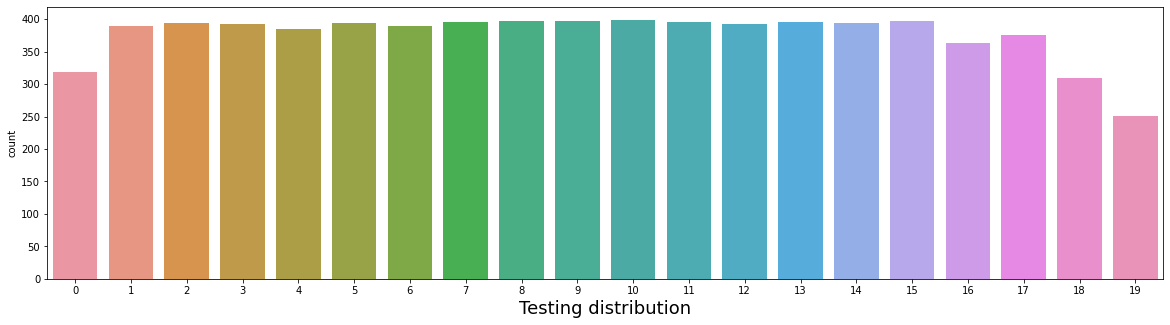

In [161]:
plt.figure(figsize=(20, 5))
sns.countplot(y_test)
plt.xlabel("Testing distribution", fontsize=18)

### Naive Bayes

In [166]:
%%time
# Text is discrete data. So the proper model needs to be used is Multinomial Naive Bayes
mnb = MultinomialNB(alpha=.01)
mnb.fit(X_train, y_train)
y_pred = mnb.predict(X_test)

CPU times: user 59.6 ms, sys: 4 ms, total: 63.5 ms
Wall time: 65.2 ms


In [167]:
val_acc = metrics.accuracy_score(y_test, y_pred)
val_acc

0.5839086563993627

In [168]:
# For the continuous variables data, Gaussian Naive Bayes is used.
# By using gaussian nb, we are assuming the underlying variables are
# with gaussian distribution.
gnb = GaussianNB()
gnb.fit(X_train.toarray(), y_train)
y_pred_2 = gnb.predict(X_test.toarray())
metrics.accuracy_score(y_test, y_pred_2) # the accuracy will be less compared to Multinomial NB

0.4528677642060542

### Tfidf

In [175]:
tfidf = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words='english')

data_train_tfidf_vectorized = tfidf.fit_transform(processed_train_data)
data_test_tfidf_vectorized = tfidf.transform(processed_test_data)

In [176]:
X_train = data_train_tfidf_vectorized
y_train = train_dataset.target
X_test = data_test_tfidf_vectorized
y_test = test_dataset.target

In [179]:
%%time
mnb = MultinomialNB(alpha=.01)
mnb.fit(X_train, y_train)
y_pred = mnb.predict(X_test)

CPU times: user 73.1 ms, sys: 24 ms, total: 97.1 ms
Wall time: 99.7 ms


In [180]:
val_acc = metrics.accuracy_score(y_test, y_pred)
val_acc # seems pretty good for a simple model

0.6125862984599044

### Analyzing Results

In [181]:
mat = metrics.confusion_matrix(y_test, y_pred)

Text(95.64, 0.5, 'Predicted')

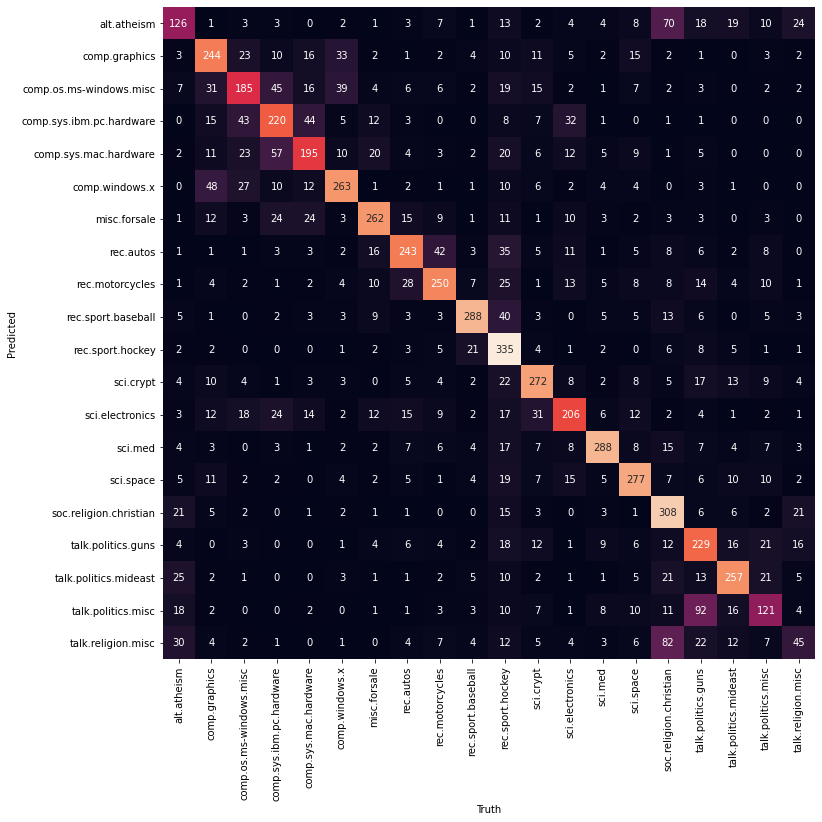

In [182]:
plt.figure(figsize=(12, 12))
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=test_dataset.target_names, yticklabels=test_dataset.target_names)
plt.xlabel('Truth')
plt.ylabel('Predicted')

Looks like religion is the most wrongly predicted class

In [183]:
report = metrics.classification_report(y_test, y_pred)

In [184]:
pprint(report)

('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.48      0.39      0.43       319\n'
 '           1       0.58      0.63      0.60       389\n'
 '           2       0.54      0.47      0.50       394\n'
 '           3       0.54      0.56      0.55       392\n'
 '           4       0.58      0.51      0.54       385\n'
 '           5       0.69      0.67      0.68       395\n'
 '           6       0.72      0.67      0.70       390\n'
 '           7       0.68      0.61      0.65       396\n'
 '           8       0.69      0.63      0.66       398\n'
 '           9       0.81      0.73      0.76       397\n'
 '          10       0.50      0.84      0.63       399\n'
 '          11       0.67      0.69      0.68       396\n'
 '          12       0.61      0.52      0.57       393\n'
 '          13       0.80      0.73      0.76       396\n'
 '          14       0.70      0.70      0.70       394\n'
 '          15       0.53      0.77      0.63     